In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./

!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 590841, done.
remote: Counting objects: 100% (1195/1195), done.
remote: Compressing objects: 100% (910/910), done.
remote: Total 590841 (delta 971), reused 327 (delta 280), pack-reused 589646 (from 5)
Receiving objects: 100% (590841/590841), 1.12 GiB | 19.21 MiB/s, done.
Resolving deltas: 100% (552006/552006), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
import os
import shutil
from pathlib import Path
import logging
import random
import warnings
import time
import io
import sys

# Data handling and transformations
import numpy as np
from PIL import Image
import cv2
import xml.etree.ElementTree as ET

# Machine learning and deep learning libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

# For image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Progress bar
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches 

# Custom libraries
import utils
import transforms as T
import engine  # Assuming this is a custom library
import logging
from engine import train_one_epoch, evaluate
from torchvision import models, transforms

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Define paths
TRAIN_IMAGES_DIR = "/kaggle/input/dataset-cs406/Enhanced_Dataset/Enhanced_Dataset/train/images"
VAL_IMAGES_DIR = "/kaggle/input/dataset-cs406/Enhanced_Dataset/Enhanced_Dataset/val/images"
TEST_IMAGES_DIR = "/kaggle/input/dataset-cs406/Enhanced_Dataset/Enhanced_Dataset/test/images"
ANNOTATIONS_DIR = "/kaggle/input/dataset-cs406/Enhanced_Dataset/Enhanced_Dataset/VOC_Annotations"


In [4]:
class VehicleDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None):
        self.images_dir = images_dir
        self.transforms = transforms
        self.annotations_dir = annotations_dir
        self.image_files = [f for f in os.listdir(images_dir) ]
        

    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        anno_file =  os.path.splitext(image_filename)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir,anno_file)
        img = Image.open(image_path).convert("RGB")
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        img_width, img_height = img.size
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            name = obj.find("name").text
            label = int(name.split('_')[-1]) 
            labels.append(label)
        if len(boxes) == 0:
            return None, None
            
        # Convert boxes to numpy array for albumentations (no manual normalization here)
        boxes = np.array(boxes, dtype=np.float32)
        
        # Apply transformations if provided
        if self.transforms:
            img = self.transforms(img)

        # Convert boxes to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Calculate area of each box
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # Prepare the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": int(idx)
        }

        return img, target

torch.Size([3, 640, 640]) 
 {'boxes': tensor([[211., 262., 449., 422.],
        [323.,   6., 463., 264.]]), 'labels': tensor([2, 2]), 'area': tensor([38080., 36120.]), 'iscrowd': tensor([0, 0]), 'image_id': 25}


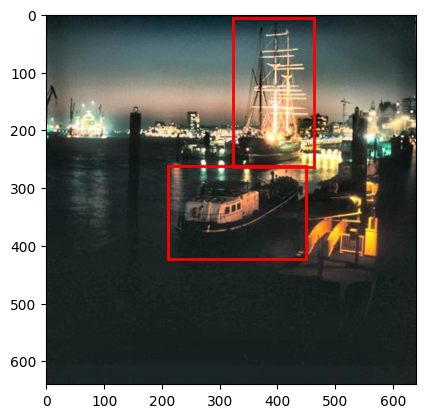

In [5]:
tmp_dataset = VehicleDataset(TRAIN_IMAGES_DIR, ANNOTATIONS_DIR)
# ========================
# Plot Image with Bounding Boxes
# ========================
def plot_img_bbox(img, target):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img.permute(1, 2, 0))  # Convert to HxWxC format for plotting
    for box in target['boxes']:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
transform = transforms.Compose([
    transforms.ToTensor(),
])
tmp_dataset = VehicleDataset(TRAIN_IMAGES_DIR, ANNOTATIONS_DIR, transform)
img, target = tmp_dataset[25]
print(img.shape, '\n', target)
plot_img_bbox(img, target)

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển ảnh PIL -> Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa 3 kênh RGB
])
# Define dataset and dataloader
train_dataset = VehicleDataset(TRAIN_IMAGES_DIR, ANNOTATIONS_DIR, transform)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*[(img, tgt) for img, tgt in x if img is not None and tgt is not None])))
# Validation setup
val_dataset = VehicleDataset(VAL_IMAGES_DIR, ANNOTATIONS_DIR, transform)
val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*[(img, tgt) for img, tgt in x if img is not None and tgt is not None])))
# Test setup
test_dataset = VehicleDataset(TEST_IMAGES_DIR, ANNOTATIONS_DIR,transform)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*[(img, tgt) for img, tgt in x if img is not None and tgt is not None])))

In [7]:
from pathlib import Path

LOG_FILE = "/kaggle/working/results/log.txt"
ERROR_FILE = "/kaggle/working/results/error.txt"

Path(LOG_FILE).parent.mkdir(parents=True, exist_ok=True)
Path(ERROR_FILE).parent.mkdir(parents=True, exist_ok=True)

logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Ensure logger level is set to INFO or DEBUG
formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

# File handler to log to the log.txt file
file_handler = logging.FileHandler(LOG_FILE, mode='w')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Stream handler to log to terminal
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)


In [8]:
def get_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    print("Model Done!")
    return model

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(6)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 20

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 222MB/s]


Model Done!


In [10]:
import torch

# Directory for saving checkpoints
CHECKPOINT_DIR = "/kaggle/working/results/checkpoints/"
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, checkpoint_dir=CHECKPOINT_DIR):
    checkpoint_path = Path(checkpoint_dir) / f"checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}")
    logger.info(f"Checkpoint saved at epoch {epoch}")

# Initialize variables for tracking the best performance
best_metric = float('-inf')  # Or float('inf') if you're using a loss function and minimizing it

# Training loop with checkpoint saving
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=20)
    metric = evaluate(model, val_dataloader, device)  # e.g., validation accuracy or validation loss
    logger.info(f"Evaluation results on validation set: {metric}")
    print(metric)

    # Save checkpoint at the end of each epoch
    save_checkpoint(model, optimizer, epoch)


print('===== Evaluate on Test =====')
logger.info("Starting evaluation on test set...")
result = evaluate(model, test_dataloader, device)
print()
logger.info(f"Evaluation results on test set: {result}")


/kaggle/working/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  0/263]  eta: 0:10:34  lr: 0.000000  loss: 3.5630 (3.5630)  loss_classifier: 2.7824 (2.7824)  loss_box_reg: 0.0447 (0.0447)  loss_objectness: 0.7057 (0.7057)  loss_rpn_box_reg: 0.0302 (0.0302)  time: 2.4117  data: 0.1662  max mem: 5805
Epoch: [0]  [ 20/263]  eta: 0:04:02  lr: 0.000008  loss: 2.2698 (2.3173)  loss_classifier: 1.9059 (1.9370)  loss_box_reg: 0.0726 (0.0900)  loss_objectness: 0.1957 (0.2671)  loss_rpn_box_reg: 0.0209 (0.0232)  time: 0.9258  data: 0.1420  max mem: 6119
Epoch: [0]  [ 40/263]  eta: 0:03:35  lr: 0.000016  loss: 0.5039 (1.4704)  loss_classifier: 0.2460 (1.1514)  loss_box_reg: 0.1471 (0.1216)  loss_objectness: 0.0704 (0.1786)  loss_rpn_box_reg: 0.0131 (0.0189)  time: 0.9350  data: 0.1460  max mem: 6119
Epoch: [0]  [ 60/263]  eta: 0:03:13  lr: 0.000023  loss: 0.4741 (1.1361)  loss_classifier: 0.2027 (0.8491)  loss_box_reg: 0.1503 (0.1312)  loss_objectness: 0.0438 (0.1396)  loss_rpn_box_reg: 0.0098 (0.0162)  time: 0.9331  data: 0.1418  max mem: 6119


2024-12-22 18:28:54,352 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fcc1a6e0>


DONE (t=0.43s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.401


2024-12-22 18:28:55,112 - INFO - Checkpoint saved at epoch 0


Checkpoint saved at epoch 0
Epoch: [1]  [  0/263]  eta: 0:03:49  lr: 0.000100  loss: 0.4328 (0.4328)  loss_classifier: 0.1724 (0.1724)  loss_box_reg: 0.2258 (0.2258)  loss_objectness: 0.0249 (0.0249)  loss_rpn_box_reg: 0.0097 (0.0097)  time: 0.8742  data: 0.0820  max mem: 6119
Epoch: [1]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.2754 (0.2988)  loss_classifier: 0.1129 (0.1235)  loss_box_reg: 0.1246 (0.1477)  loss_objectness: 0.0164 (0.0203)  loss_rpn_box_reg: 0.0076 (0.0073)  time: 0.8686  data: 0.0758  max mem: 6119
Epoch: [1]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.2359 (0.2850)  loss_classifier: 0.1048 (0.1192)  loss_box_reg: 0.1155 (0.1403)  loss_objectness: 0.0125 (0.0181)  loss_rpn_box_reg: 0.0069 (0.0074)  time: 0.8696  data: 0.0747  max mem: 6119
Epoch: [1]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.2689 (0.2909)  loss_classifier: 0.1172 (0.1218)  loss_box_reg: 0.1319 (0.1428)  loss_objectness: 0.0167 (0.0184)  loss_rpn_box_reg: 0.0074 (0.0079)  time: 0.8701  

2024-12-22 18:33:24,802 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7898b858cbe0>


DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.165
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.442


2024-12-22 18:33:25,552 - INFO - Checkpoint saved at epoch 1


Checkpoint saved at epoch 1
Epoch: [2]  [  0/263]  eta: 0:03:48  lr: 0.000100  loss: 0.3239 (0.3239)  loss_classifier: 0.1216 (0.1216)  loss_box_reg: 0.1770 (0.1770)  loss_objectness: 0.0181 (0.0181)  loss_rpn_box_reg: 0.0072 (0.0072)  time: 0.8676  data: 0.0737  max mem: 6120
Epoch: [2]  [ 20/263]  eta: 0:03:30  lr: 0.000100  loss: 0.1836 (0.2101)  loss_classifier: 0.0687 (0.0826)  loss_box_reg: 0.1062 (0.1137)  loss_objectness: 0.0070 (0.0083)  loss_rpn_box_reg: 0.0050 (0.0055)  time: 0.8676  data: 0.0717  max mem: 6120
Epoch: [2]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.1913 (0.2201)  loss_classifier: 0.0813 (0.0852)  loss_box_reg: 0.1121 (0.1212)  loss_objectness: 0.0061 (0.0079)  loss_rpn_box_reg: 0.0051 (0.0057)  time: 0.8711  data: 0.0763  max mem: 6120
Epoch: [2]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.2156 (0.2166)  loss_classifier: 0.0749 (0.0828)  loss_box_reg: 0.1263 (0.1211)  loss_objectness: 0.0036 (0.0071)  loss_rpn_box_reg: 0.0045 (0.0055)  time: 0.8650  

2024-12-22 18:37:53,792 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fd6b3fd0>


DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.201
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.266
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.466


2024-12-22 18:37:54,544 - INFO - Checkpoint saved at epoch 2


Checkpoint saved at epoch 2
Epoch: [3]  [  0/263]  eta: 0:03:51  lr: 0.000100  loss: 0.2479 (0.2479)  loss_classifier: 0.0703 (0.0703)  loss_box_reg: 0.1573 (0.1573)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0091 (0.0091)  time: 0.8801  data: 0.0869  max mem: 6120
Epoch: [3]  [ 20/263]  eta: 0:03:29  lr: 0.000100  loss: 0.1785 (0.1902)  loss_classifier: 0.0632 (0.0656)  loss_box_reg: 0.0979 (0.1137)  loss_objectness: 0.0038 (0.0051)  loss_rpn_box_reg: 0.0050 (0.0057)  time: 0.8623  data: 0.0731  max mem: 6120
Epoch: [3]  [ 40/263]  eta: 0:03:12  lr: 0.000100  loss: 0.1450 (0.1936)  loss_classifier: 0.0562 (0.0674)  loss_box_reg: 0.0905 (0.1144)  loss_objectness: 0.0055 (0.0059)  loss_rpn_box_reg: 0.0039 (0.0058)  time: 0.8659  data: 0.0719  max mem: 6120
Epoch: [3]  [ 60/263]  eta: 0:02:55  lr: 0.000100  loss: 0.1766 (0.1891)  loss_classifier: 0.0608 (0.0653)  loss_box_reg: 0.1066 (0.1127)  loss_objectness: 0.0037 (0.0055)  loss_rpn_box_reg: 0.0045 (0.0056)  time: 0.8662  

2024-12-22 18:42:22,834 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fd6e5330>


2024-12-22 18:42:23,584 - INFO - Checkpoint saved at epoch 3


Checkpoint saved at epoch 3
Epoch: [4]  [  0/263]  eta: 0:03:48  lr: 0.000100  loss: 0.1832 (0.1832)  loss_classifier: 0.0648 (0.0648)  loss_box_reg: 0.1082 (0.1082)  loss_objectness: 0.0025 (0.0025)  loss_rpn_box_reg: 0.0077 (0.0077)  time: 0.8696  data: 0.0737  max mem: 6120
Epoch: [4]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.1311 (0.1368)  loss_classifier: 0.0418 (0.0442)  loss_box_reg: 0.0823 (0.0853)  loss_objectness: 0.0030 (0.0032)  loss_rpn_box_reg: 0.0035 (0.0042)  time: 0.8695  data: 0.0724  max mem: 6120
Epoch: [4]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.1388 (0.1467)  loss_classifier: 0.0439 (0.0499)  loss_box_reg: 0.0854 (0.0887)  loss_objectness: 0.0025 (0.0039)  loss_rpn_box_reg: 0.0034 (0.0042)  time: 0.8698  data: 0.0738  max mem: 6120
Epoch: [4]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.1470 (0.1487)  loss_classifier: 0.0471 (0.0505)  loss_box_reg: 0.0953 (0.0903)  loss_objectness: 0.0023 (0.0037)  loss_rpn_box_reg: 0.0036 (0.0041)  time: 0.8650  

2024-12-22 18:46:52,143 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fd6e6080>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3640 (0.3643)  evaluator_time: 0.0077 (0.0083)  time: 0.4587  data: 0.0761  max mem: 6120
Test: Total time: 0:00:34 (0.4579 s / it)
Averaged stats: model_time: 0.3640 (0.3643)  evaluator_time: 0.0077 (0.0083)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.424
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 18:46:52,896 - INFO - Checkpoint saved at epoch 4


Checkpoint saved at epoch 4
Epoch: [5]  [  0/263]  eta: 0:03:45  lr: 0.000100  loss: 0.1281 (0.1281)  loss_classifier: 0.0401 (0.0401)  loss_box_reg: 0.0840 (0.0840)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 0.8577  data: 0.0665  max mem: 6120
Epoch: [5]  [ 20/263]  eta: 0:03:30  lr: 0.000100  loss: 0.1312 (0.1426)  loss_classifier: 0.0423 (0.0446)  loss_box_reg: 0.0815 (0.0898)  loss_objectness: 0.0051 (0.0044)  loss_rpn_box_reg: 0.0029 (0.0037)  time: 0.8667  data: 0.0716  max mem: 6120
Epoch: [5]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.1175 (0.1355)  loss_classifier: 0.0340 (0.0417)  loss_box_reg: 0.0751 (0.0865)  loss_objectness: 0.0026 (0.0035)  loss_rpn_box_reg: 0.0034 (0.0038)  time: 0.8705  data: 0.0752  max mem: 6120
Epoch: [5]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.1492 (0.1413)  loss_classifier: 0.0495 (0.0431)  loss_box_reg: 0.0938 (0.0908)  loss_objectness: 0.0029 (0.0033)  loss_rpn_box_reg: 0.0044 (0.0041)  time: 0.8712  

2024-12-22 18:51:22,127 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x789809fc8f70>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3637 (0.3647)  evaluator_time: 0.0071 (0.0102)  time: 0.4571  data: 0.0750  max mem: 6120
Test: Total time: 0:00:34 (0.4619 s / it)
Averaged stats: model_time: 0.3637 (0.3647)  evaluator_time: 0.0071 (0.0102)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 18:51:22,889 - INFO - Checkpoint saved at epoch 5


Checkpoint saved at epoch 5
Epoch: [6]  [  0/263]  eta: 0:03:46  lr: 0.000100  loss: 0.2153 (0.2153)  loss_classifier: 0.0697 (0.0697)  loss_box_reg: 0.1351 (0.1351)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0081 (0.0081)  time: 0.8602  data: 0.0687  max mem: 6120
Epoch: [6]  [ 20/263]  eta: 0:03:29  lr: 0.000100  loss: 0.1080 (0.1262)  loss_classifier: 0.0350 (0.0390)  loss_box_reg: 0.0728 (0.0807)  loss_objectness: 0.0012 (0.0025)  loss_rpn_box_reg: 0.0035 (0.0041)  time: 0.8643  data: 0.0700  max mem: 6120
Epoch: [6]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.0943 (0.1188)  loss_classifier: 0.0291 (0.0360)  loss_box_reg: 0.0637 (0.0766)  loss_objectness: 0.0015 (0.0024)  loss_rpn_box_reg: 0.0036 (0.0039)  time: 0.8710  data: 0.0758  max mem: 6120
Epoch: [6]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.1083 (0.1184)  loss_classifier: 0.0297 (0.0355)  loss_box_reg: 0.0715 (0.0767)  loss_objectness: 0.0014 (0.0024)  loss_rpn_box_reg: 0.0032 (0.0039)  time: 0.8694  

2024-12-22 18:55:51,399 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fcb2a7d0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3647 (0.3647)  evaluator_time: 0.0059 (0.0064)  time: 0.4558  data: 0.0751  max mem: 6120
Test: Total time: 0:00:34 (0.4565 s / it)
Averaged stats: model_time: 0.3647 (0.3647)  evaluator_time: 0.0059 (0.0064)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 18:55:52,168 - INFO - Checkpoint saved at epoch 6


Checkpoint saved at epoch 6
Epoch: [7]  [  0/263]  eta: 0:03:54  lr: 0.000100  loss: 0.0996 (0.0996)  loss_classifier: 0.0242 (0.0242)  loss_box_reg: 0.0689 (0.0689)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 0.8915  data: 0.0892  max mem: 6120
Epoch: [7]  [ 20/263]  eta: 0:03:30  lr: 0.000100  loss: 0.1091 (0.1141)  loss_classifier: 0.0299 (0.0319)  loss_box_reg: 0.0674 (0.0760)  loss_objectness: 0.0020 (0.0022)  loss_rpn_box_reg: 0.0040 (0.0040)  time: 0.8630  data: 0.0730  max mem: 6120
Epoch: [7]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.0936 (0.1070)  loss_classifier: 0.0255 (0.0302)  loss_box_reg: 0.0649 (0.0713)  loss_objectness: 0.0007 (0.0020)  loss_rpn_box_reg: 0.0028 (0.0036)  time: 0.8688  data: 0.0744  max mem: 6120
Epoch: [7]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0882 (0.1036)  loss_classifier: 0.0250 (0.0296)  loss_box_reg: 0.0584 (0.0687)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0030 (0.0035)  time: 0.8686  

2024-12-22 19:00:21,409 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x789809fc8f70>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3644 (0.3649)  evaluator_time: 0.0061 (0.0065)  time: 0.4555  data: 0.0746  max mem: 6120
Test: Total time: 0:00:34 (0.4584 s / it)
Averaged stats: model_time: 0.3644 (0.3649)  evaluator_time: 0.0061 (0.0065)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:00:22,165 - INFO - Checkpoint saved at epoch 7


Checkpoint saved at epoch 7
Epoch: [8]  [  0/263]  eta: 0:03:50  lr: 0.000100  loss: 0.0510 (0.0510)  loss_classifier: 0.0160 (0.0160)  loss_box_reg: 0.0300 (0.0300)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 0.8761  data: 0.0759  max mem: 6120
Epoch: [8]  [ 20/263]  eta: 0:03:30  lr: 0.000100  loss: 0.0712 (0.0784)  loss_classifier: 0.0185 (0.0203)  loss_box_reg: 0.0500 (0.0546)  loss_objectness: 0.0007 (0.0008)  loss_rpn_box_reg: 0.0022 (0.0026)  time: 0.8642  data: 0.0734  max mem: 6120
Epoch: [8]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.0912 (0.0889)  loss_classifier: 0.0261 (0.0239)  loss_box_reg: 0.0591 (0.0608)  loss_objectness: 0.0017 (0.0012)  loss_rpn_box_reg: 0.0032 (0.0030)  time: 0.8704  data: 0.0743  max mem: 6120
Epoch: [8]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0766 (0.0850)  loss_classifier: 0.0214 (0.0231)  loss_box_reg: 0.0483 (0.0576)  loss_objectness: 0.0012 (0.0013)  loss_rpn_box_reg: 0.0025 (0.0030)  time: 0.8692  

2024-12-22 19:04:50,886 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fe097850>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3622 (0.3640)  evaluator_time: 0.0051 (0.0056)  time: 0.4534  data: 0.0747  max mem: 6120
Test: Total time: 0:00:34 (0.4565 s / it)
Averaged stats: model_time: 0.3622 (0.3640)  evaluator_time: 0.0051 (0.0056)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.399
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.293
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:04:51,655 - INFO - Checkpoint saved at epoch 8


Checkpoint saved at epoch 8
Epoch: [9]  [  0/263]  eta: 0:03:50  lr: 0.000100  loss: 0.1322 (0.1322)  loss_classifier: 0.0340 (0.0340)  loss_box_reg: 0.0949 (0.0949)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 0.8760  data: 0.0782  max mem: 6120
Epoch: [9]  [ 20/263]  eta: 0:03:33  lr: 0.000100  loss: 0.0853 (0.0946)  loss_classifier: 0.0225 (0.0255)  loss_box_reg: 0.0537 (0.0642)  loss_objectness: 0.0010 (0.0017)  loss_rpn_box_reg: 0.0028 (0.0031)  time: 0.8770  data: 0.0813  max mem: 6120
Epoch: [9]  [ 40/263]  eta: 0:03:14  lr: 0.000100  loss: 0.0804 (0.0888)  loss_classifier: 0.0230 (0.0258)  loss_box_reg: 0.0539 (0.0592)  loss_objectness: 0.0007 (0.0013)  loss_rpn_box_reg: 0.0017 (0.0026)  time: 0.8697  data: 0.0737  max mem: 6120
Epoch: [9]  [ 60/263]  eta: 0:02:57  lr: 0.000100  loss: 0.0799 (0.0894)  loss_classifier: 0.0280 (0.0274)  loss_box_reg: 0.0510 (0.0581)  loss_objectness: 0.0007 (0.0013)  loss_rpn_box_reg: 0.0023 (0.0025)  time: 0.8692  

2024-12-22 19:09:20,545 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7898b858eef0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3636 (0.3643)  evaluator_time: 0.0052 (0.0057)  time: 0.4543  data: 0.0749  max mem: 6120
Test: Total time: 0:00:34 (0.4554 s / it)
Averaged stats: model_time: 0.3636 (0.3643)  evaluator_time: 0.0052 (0.0057)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.418
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:09:21,295 - INFO - Checkpoint saved at epoch 9


Checkpoint saved at epoch 9
Epoch: [10]  [  0/263]  eta: 0:03:50  lr: 0.000100  loss: 0.0930 (0.0930)  loss_classifier: 0.0246 (0.0246)  loss_box_reg: 0.0603 (0.0603)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 0.8780  data: 0.0870  max mem: 6120
Epoch: [10]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.0687 (0.0726)  loss_classifier: 0.0191 (0.0199)  loss_box_reg: 0.0462 (0.0487)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0021 (0.0025)  time: 0.8687  data: 0.0715  max mem: 6120
Epoch: [10]  [ 40/263]  eta: 0:03:14  lr: 0.000100  loss: 0.0722 (0.0775)  loss_classifier: 0.0206 (0.0213)  loss_box_reg: 0.0493 (0.0521)  loss_objectness: 0.0013 (0.0016)  loss_rpn_box_reg: 0.0021 (0.0025)  time: 0.8725  data: 0.0766  max mem: 6121
Epoch: [10]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0720 (0.0782)  loss_classifier: 0.0196 (0.0211)  loss_box_reg: 0.0514 (0.0534)  loss_objectness: 0.0007 (0.0014)  loss_rpn_box_reg: 0.0021 (0.0024)  time: 0.86

2024-12-22 19:13:50,007 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fe097850>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3635 (0.3644)  evaluator_time: 0.0052 (0.0057)  time: 0.4536  data: 0.0747  max mem: 6121
Test: Total time: 0:00:34 (0.4555 s / it)
Averaged stats: model_time: 0.3635 (0.3644)  evaluator_time: 0.0052 (0.0057)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:13:50,777 - INFO - Checkpoint saved at epoch 10


Checkpoint saved at epoch 10
Epoch: [11]  [  0/263]  eta: 0:03:50  lr: 0.000100  loss: 0.0771 (0.0771)  loss_classifier: 0.0227 (0.0227)  loss_box_reg: 0.0514 (0.0514)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 0.8779  data: 0.0830  max mem: 6121
Epoch: [11]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.0596 (0.0669)  loss_classifier: 0.0168 (0.0191)  loss_box_reg: 0.0385 (0.0450)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0017 (0.0020)  time: 0.8699  data: 0.0722  max mem: 6121
Epoch: [11]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.0668 (0.0718)  loss_classifier: 0.0214 (0.0202)  loss_box_reg: 0.0474 (0.0485)  loss_objectness: 0.0005 (0.0009)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 0.8658  data: 0.0721  max mem: 6121
Epoch: [11]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0675 (0.0716)  loss_classifier: 0.0169 (0.0199)  loss_box_reg: 0.0457 (0.0483)  loss_objectness: 0.0015 (0.0011)  loss_rpn_box_reg: 0.0024 (0.0023)  time: 0.8

2024-12-22 19:18:19,311 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fe10b190>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3638 (0.3647)  evaluator_time: 0.0053 (0.0056)  time: 0.4561  data: 0.0764  max mem: 6121
Test: Total time: 0:00:34 (0.4572 s / it)
Averaged stats: model_time: 0.3638 (0.3647)  evaluator_time: 0.0053 (0.0056)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.392
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:18:20,080 - INFO - Checkpoint saved at epoch 11


Checkpoint saved at epoch 11
Epoch: [12]  [  0/263]  eta: 0:03:46  lr: 0.000100  loss: 0.0598 (0.0598)  loss_classifier: 0.0159 (0.0159)  loss_box_reg: 0.0413 (0.0413)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 0.8616  data: 0.0683  max mem: 6121
Epoch: [12]  [ 20/263]  eta: 0:03:29  lr: 0.000100  loss: 0.0728 (0.0797)  loss_classifier: 0.0198 (0.0227)  loss_box_reg: 0.0498 (0.0535)  loss_objectness: 0.0008 (0.0010)  loss_rpn_box_reg: 0.0022 (0.0024)  time: 0.8602  data: 0.0714  max mem: 6121
Epoch: [12]  [ 40/263]  eta: 0:03:12  lr: 0.000100  loss: 0.0743 (0.0792)  loss_classifier: 0.0189 (0.0222)  loss_box_reg: 0.0509 (0.0538)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0018 (0.0023)  time: 0.8697  data: 0.0736  max mem: 6121
Epoch: [12]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0652 (0.0741)  loss_classifier: 0.0172 (0.0209)  loss_box_reg: 0.0445 (0.0501)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0019 (0.0022)  time: 0.8

2024-12-22 19:22:48,791 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7898b858dcc0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3650 (0.3649)  evaluator_time: 0.0053 (0.0056)  time: 0.4558  data: 0.0754  max mem: 6121
Test: Total time: 0:00:34 (0.4562 s / it)
Averaged stats: model_time: 0.3650 (0.3649)  evaluator_time: 0.0053 (0.0056)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:22:49,541 - INFO - Checkpoint saved at epoch 12


Checkpoint saved at epoch 12
Epoch: [13]  [  0/263]  eta: 0:03:49  lr: 0.000100  loss: 0.0476 (0.0476)  loss_classifier: 0.0119 (0.0119)  loss_box_reg: 0.0341 (0.0341)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.8710  data: 0.0763  max mem: 6121
Epoch: [13]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.0637 (0.0673)  loss_classifier: 0.0162 (0.0171)  loss_box_reg: 0.0447 (0.0469)  loss_objectness: 0.0008 (0.0013)  loss_rpn_box_reg: 0.0021 (0.0020)  time: 0.8709  data: 0.0798  max mem: 6121
Epoch: [13]  [ 40/263]  eta: 0:03:14  lr: 0.000100  loss: 0.0579 (0.0669)  loss_classifier: 0.0174 (0.0181)  loss_box_reg: 0.0376 (0.0457)  loss_objectness: 0.0003 (0.0010)  loss_rpn_box_reg: 0.0020 (0.0022)  time: 0.8696  data: 0.0738  max mem: 6121
Epoch: [13]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0635 (0.0677)  loss_classifier: 0.0198 (0.0187)  loss_box_reg: 0.0394 (0.0458)  loss_objectness: 0.0005 (0.0010)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 0.8

2024-12-22 19:27:18,867 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fcc184c0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3639 (0.3647)  evaluator_time: 0.0048 (0.0055)  time: 0.4536  data: 0.0742  max mem: 6121
Test: Total time: 0:00:34 (0.4582 s / it)
Averaged stats: model_time: 0.3639 (0.3647)  evaluator_time: 0.0048 (0.0055)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:27:19,612 - INFO - Checkpoint saved at epoch 13


Checkpoint saved at epoch 13
Epoch: [14]  [  0/263]  eta: 0:03:50  lr: 0.000100  loss: 0.0802 (0.0802)  loss_classifier: 0.0181 (0.0181)  loss_box_reg: 0.0589 (0.0589)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 0.8751  data: 0.0809  max mem: 6121
Epoch: [14]  [ 20/263]  eta: 0:03:30  lr: 0.000100  loss: 0.0603 (0.0693)  loss_classifier: 0.0168 (0.0186)  loss_box_reg: 0.0423 (0.0478)  loss_objectness: 0.0006 (0.0009)  loss_rpn_box_reg: 0.0016 (0.0021)  time: 0.8642  data: 0.0742  max mem: 6121
Epoch: [14]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.0574 (0.0662)  loss_classifier: 0.0171 (0.0187)  loss_box_reg: 0.0365 (0.0448)  loss_objectness: 0.0004 (0.0007)  loss_rpn_box_reg: 0.0019 (0.0020)  time: 0.8741  data: 0.0775  max mem: 6121
Epoch: [14]  [ 60/263]  eta: 0:02:57  lr: 0.000100  loss: 0.0554 (0.0677)  loss_classifier: 0.0156 (0.0189)  loss_box_reg: 0.0369 (0.0459)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 0.8

2024-12-22 19:31:50,022 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fe0977f0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3647 (0.3653)  evaluator_time: 0.0053 (0.0057)  time: 0.4563  data: 0.0762  max mem: 6121
Test: Total time: 0:00:34 (0.4570 s / it)
Averaged stats: model_time: 0.3647 (0.3653)  evaluator_time: 0.0053 (0.0057)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.389
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.296
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:31:50,815 - INFO - Checkpoint saved at epoch 14


Checkpoint saved at epoch 14
Epoch: [15]  [  0/263]  eta: 0:03:50  lr: 0.000100  loss: 0.0892 (0.0892)  loss_classifier: 0.0246 (0.0246)  loss_box_reg: 0.0615 (0.0615)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 0.8766  data: 0.0782  max mem: 6121
Epoch: [15]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.0683 (0.0700)  loss_classifier: 0.0181 (0.0189)  loss_box_reg: 0.0462 (0.0476)  loss_objectness: 0.0005 (0.0010)  loss_rpn_box_reg: 0.0020 (0.0025)  time: 0.8710  data: 0.0759  max mem: 6121
Epoch: [15]  [ 40/263]  eta: 0:03:14  lr: 0.000100  loss: 0.0630 (0.0677)  loss_classifier: 0.0169 (0.0185)  loss_box_reg: 0.0450 (0.0457)  loss_objectness: 0.0007 (0.0011)  loss_rpn_box_reg: 0.0017 (0.0023)  time: 0.8701  data: 0.0733  max mem: 6121
Epoch: [15]  [ 60/263]  eta: 0:02:57  lr: 0.000100  loss: 0.0546 (0.0644)  loss_classifier: 0.0164 (0.0176)  loss_box_reg: 0.0365 (0.0437)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0016 (0.0021)  time: 0.8

2024-12-22 19:36:19,164 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7898d7d2a620>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3629 (0.3644)  evaluator_time: 0.0050 (0.0056)  time: 0.4524  data: 0.0738  max mem: 6121
Test: Total time: 0:00:34 (0.4553 s / it)
Averaged stats: model_time: 0.3629 (0.3644)  evaluator_time: 0.0050 (0.0056)
Accumulating evaluation results...
DONE (t=0.11s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:36:19,916 - INFO - Checkpoint saved at epoch 15


Checkpoint saved at epoch 15
Epoch: [16]  [  0/263]  eta: 0:03:52  lr: 0.000100  loss: 0.0595 (0.0595)  loss_classifier: 0.0166 (0.0166)  loss_box_reg: 0.0416 (0.0416)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.8852  data: 0.0918  max mem: 6121
Epoch: [16]  [ 20/263]  eta: 0:03:30  lr: 0.000100  loss: 0.0537 (0.0587)  loss_classifier: 0.0150 (0.0160)  loss_box_reg: 0.0371 (0.0402)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0016 (0.0017)  time: 0.8654  data: 0.0721  max mem: 6121
Epoch: [16]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.0537 (0.0594)  loss_classifier: 0.0134 (0.0162)  loss_box_reg: 0.0386 (0.0407)  loss_objectness: 0.0006 (0.0008)  loss_rpn_box_reg: 0.0016 (0.0017)  time: 0.8730  data: 0.0788  max mem: 6121
Epoch: [16]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0532 (0.0583)  loss_classifier: 0.0155 (0.0159)  loss_box_reg: 0.0340 (0.0398)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 0.8

2024-12-22 19:40:48,884 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7898d7d2a680>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3649 (0.3652)  evaluator_time: 0.0058 (0.0064)  time: 0.4565  data: 0.0754  max mem: 6121
Test: Total time: 0:00:34 (0.4570 s / it)
Averaged stats: model_time: 0.3649 (0.3652)  evaluator_time: 0.0058 (0.0064)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:40:49,645 - INFO - Checkpoint saved at epoch 16


Checkpoint saved at epoch 16
Epoch: [17]  [  0/263]  eta: 0:03:52  lr: 0.000100  loss: 0.0263 (0.0263)  loss_classifier: 0.0102 (0.0102)  loss_box_reg: 0.0143 (0.0143)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 0.8839  data: 0.0879  max mem: 6121
Epoch: [17]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.0594 (0.0635)  loss_classifier: 0.0169 (0.0184)  loss_box_reg: 0.0389 (0.0402)  loss_objectness: 0.0023 (0.0022)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 0.8711  data: 0.0750  max mem: 6121
Epoch: [17]  [ 40/263]  eta: 0:03:14  lr: 0.000100  loss: 0.0565 (0.0627)  loss_classifier: 0.0162 (0.0184)  loss_box_reg: 0.0352 (0.0400)  loss_objectness: 0.0008 (0.0016)  loss_rpn_box_reg: 0.0022 (0.0026)  time: 0.8737  data: 0.0787  max mem: 6121
Epoch: [17]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0731 (0.0665)  loss_classifier: 0.0217 (0.0190)  loss_box_reg: 0.0513 (0.0433)  loss_objectness: 0.0009 (0.0015)  loss_rpn_box_reg: 0.0022 (0.0026)  time: 0.8

2024-12-22 19:45:18,311 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fd6e9720>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3638 (0.3644)  evaluator_time: 0.0048 (0.0052)  time: 0.4528  data: 0.0743  max mem: 6121
Test: Total time: 0:00:34 (0.4570 s / it)
Averaged stats: model_time: 0.3638 (0.3644)  evaluator_time: 0.0048 (0.0052)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.397
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:45:19,066 - INFO - Checkpoint saved at epoch 17


Checkpoint saved at epoch 17
Epoch: [18]  [  0/263]  eta: 0:03:47  lr: 0.000100  loss: 0.0574 (0.0574)  loss_classifier: 0.0138 (0.0138)  loss_box_reg: 0.0408 (0.0408)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 0.8665  data: 0.0732  max mem: 6121
Epoch: [18]  [ 20/263]  eta: 0:03:31  lr: 0.000100  loss: 0.0600 (0.0586)  loss_classifier: 0.0156 (0.0158)  loss_box_reg: 0.0399 (0.0404)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0016 (0.0017)  time: 0.8706  data: 0.0752  max mem: 6121
Epoch: [18]  [ 40/263]  eta: 0:03:14  lr: 0.000100  loss: 0.0508 (0.0558)  loss_classifier: 0.0137 (0.0149)  loss_box_reg: 0.0349 (0.0385)  loss_objectness: 0.0005 (0.0007)  loss_rpn_box_reg: 0.0015 (0.0016)  time: 0.8701  data: 0.0772  max mem: 6121
Epoch: [18]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0584 (0.0556)  loss_classifier: 0.0150 (0.0149)  loss_box_reg: 0.0372 (0.0383)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0020 (0.0017)  time: 0.8

2024-12-22 19:49:47,638 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fd6ddd80>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3645 (0.3647)  evaluator_time: 0.0056 (0.0061)  time: 0.4551  data: 0.0752  max mem: 6121
Test: Total time: 0:00:34 (0.4558 s / it)
Averaged stats: model_time: 0.3645 (0.3647)  evaluator_time: 0.0056 (0.0061)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:49:48,458 - INFO - Checkpoint saved at epoch 18


Checkpoint saved at epoch 18
Epoch: [19]  [  0/263]  eta: 0:03:49  lr: 0.000100  loss: 0.0826 (0.0826)  loss_classifier: 0.0278 (0.0278)  loss_box_reg: 0.0527 (0.0527)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 0.8723  data: 0.0794  max mem: 6121
Epoch: [19]  [ 20/263]  eta: 0:03:30  lr: 0.000100  loss: 0.1180 (0.1213)  loss_classifier: 0.0489 (0.0544)  loss_box_reg: 0.0528 (0.0582)  loss_objectness: 0.0047 (0.0054)  loss_rpn_box_reg: 0.0030 (0.0034)  time: 0.8652  data: 0.0758  max mem: 6121
Epoch: [19]  [ 40/263]  eta: 0:03:13  lr: 0.000100  loss: 0.1026 (0.1183)  loss_classifier: 0.0391 (0.0488)  loss_box_reg: 0.0550 (0.0604)  loss_objectness: 0.0034 (0.0054)  loss_rpn_box_reg: 0.0041 (0.0038)  time: 0.8710  data: 0.0764  max mem: 6121
Epoch: [19]  [ 60/263]  eta: 0:02:56  lr: 0.000100  loss: 0.0973 (0.1124)  loss_classifier: 0.0319 (0.0450)  loss_box_reg: 0.0509 (0.0585)  loss_objectness: 0.0037 (0.0052)  loss_rpn_box_reg: 0.0032 (0.0037)  time: 0.8

2024-12-22 19:54:16,775 - INFO - Evaluation results on validation set: <coco_eval.CocoEvaluator object at 0x7897fe109ed0>


Test:  [74/75]  eta: 0:00:00  model_time: 0.3641 (0.3647)  evaluator_time: 0.0054 (0.0057)  time: 0.4545  data: 0.0745  max mem: 6121
Test: Total time: 0:00:34 (0.4561 s / it)
Averaged stats: model_time: 0.3641 (0.3647)  evaluator_time: 0.0054 (0.0057)
Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.

2024-12-22 19:54:17,552 - INFO - Checkpoint saved at epoch 19
2024-12-22 19:54:17,554 - INFO - Starting evaluation on test set...


Checkpoint saved at epoch 19
===== Evaluate on Test =====
creating index...
index created!
Test:  [ 0/38]  eta: 0:00:17  model_time: 0.3653 (0.3653)  evaluator_time: 0.0066 (0.0066)  time: 0.4574  data: 0.0764  max mem: 6121


2024-12-22 19:54:41,793 - INFO - Evaluation results on test set: <coco_eval.CocoEvaluator object at 0x7898b858ca60>


Test:  [37/38]  eta: 0:00:00  model_time: 0.3635 (0.3597)  evaluator_time: 0.0047 (0.0053)  time: 0.4499  data: 0.0806  max mem: 6121
Test: Total time: 0:00:17 (0.4581 s / it)
Averaged stats: model_time: 0.3635 (0.3597)  evaluator_time: 0.0047 (0.0053)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.367
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.